In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt


DEVICE = torch.device("cpu")

# --- CONFIGURATION DES CHEMINS ---
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(),"..", "..", "data", "auto_vi", "pipe_staple", "pipe_staple"))

print(f"Racine des données : {BASE_DIR}")

# Hyperparamètres
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10

Racine des données : /home/antoine/upb/aifortdm/data/auto_vi/pipe_staple/pipe_staple


In [21]:
def prepare_file_list(base_dir):
    """
    Parcourt l'arborescence spécifique pour récupérer :
    - Label 0 (Good) : train/good + test/good
    - Label 1 (Bad)  : test/missing (ou autres dossiers de défauts)
    """
    image_paths = []
    labels = []
    
    # 1. Récupérer les images "Good" (Label 0)
    good_paths = glob.glob(os.path.join(base_dir, "train", "good", "*.png")) + \
                 glob.glob(os.path.join(base_dir, "test", "good", "*.png"))
    
    for p in good_paths:
        image_paths.append(p)
        labels.append(0) 
        
    # 2. Récupérer les images "Defect" (Label 1)
    defect_paths = glob.glob(os.path.join(base_dir, "test", "missing", "*.png"))
    

    for p in defect_paths:
        image_paths.append(p)
        labels.append(1)
        
    print(f"Total images 'Good' (0): {labels.count(0)}")
    print(f"Total images 'Defect' (1): {labels.count(1)}")
    
    return np.array(image_paths), np.array(labels)


all_paths, all_labels = prepare_file_list(BASE_DIR)

X_train, X_test, y_train, y_test = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Taille Train : {len(X_train)}")
print(f"Taille Test  : {len(X_test)}")

Total images 'Good' (0): 379
Total images 'Defect' (1): 117
Taille Train : 396
Taille Test  : 100


In [22]:
class IndustrialDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = IndustrialDataset(X_train, y_train, transform=data_transform)
test_dataset = IndustrialDataset(X_test, y_test, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolution 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) # 128 -> 64
        
        # Convolution 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) # 64 -> 32
        
        # Convolution 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2) # 32 -> 16
        
        # Fully Connected
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2) # 2 classes (Good/Bad)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
test_accs = []

print("--- Début de l'entraînement (Centralisé) ---")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Évaluation rapide fin d'époque
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    test_accs.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Test Acc: {epoch_acc:.2f}%")

print("--- Entraînement terminé ---")


torch.save(model.state_dict(), "centralized_model.pth")

--- Début de l'entraînement (Centralisé) ---
Epoch 1/10 | Loss: 0.6052 | Test Acc: 76.00%
Epoch 2/10 | Loss: 0.4273 | Test Acc: 83.00%
Epoch 3/10 | Loss: 0.0977 | Test Acc: 100.00%
Epoch 4/10 | Loss: 0.0221 | Test Acc: 98.00%
Epoch 5/10 | Loss: 0.0255 | Test Acc: 100.00%
Epoch 6/10 | Loss: 0.0201 | Test Acc: 100.00%
Epoch 7/10 | Loss: 0.0142 | Test Acc: 100.00%
Epoch 8/10 | Loss: 0.0077 | Test Acc: 100.00%
Epoch 9/10 | Loss: 0.0022 | Test Acc: 100.00%
Epoch 10/10 | Loss: 0.0053 | Test Acc: 100.00%
--- Entraînement terminé ---



--- Rapport Détaillé ---
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00        76
      Defect       1.00      1.00      1.00        24

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



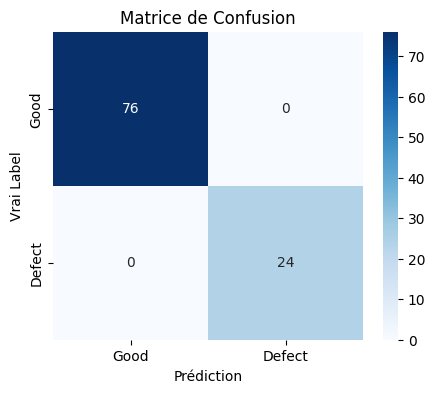

AUC Score: 1.0000


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns


model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        
        # Probabilités (softmax)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 1. Rapport de classification
print("\n--- Rapport Détaillé ---")
print(classification_report(all_labels, all_preds, target_names=["Good", "Defect"]))

# 2. Matrice de Confusion 
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Good", "Defect"], yticklabels=["Good", "Defect"])
plt.xlabel('Prédiction')
plt.ylabel('Vrai Label')
plt.title('Matrice de Confusion')
plt.show()

# 3. Score AUC 
try:
    # On prend la probabilité de la classe 1 (Defect)
    auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    print(f"AUC Score: {auc:.4f}")
except Exception as e:
    print(f"Erreur AUC: {e}")